# Example with Resnet50

In [1]:
# Reference: https://keras.io/api/applications/#resnet50
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
import numpy as np
import pandas as pd

baseModel = ResNet50(weights="imagenet", include_top=True, input_tensor=Input(shape=(224, 224, 3)))

In [2]:
baseModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [3]:
def classify_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds # [(class, description, probability)]


In [4]:
img_path = 'dataset-resized/test/cardboard/cardboard116.jpg'
preds = classify_image(img_path, baseModel)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n04548362', 'wallet', 0.67243), ('n03014705', 'chest', 0.12304134), ('n02971356', 'carton', 0.038968828)]


In [5]:
img_path = 'dataset-resized/training/glass/glass10.jpg'
preds = classify_image(img_path, baseModel)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n03983396', 'pop_bottle', 0.20891705), ('n04070727', 'refrigerator', 0.20570242), ('n03742115', 'medicine_chest', 0.1386032)]


In [6]:
# Reference: https://www.pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(6, activation="softmax")(headModel)
model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
# loop over all layers in the base model and freeze them so they will not be updated during the training process
for layer in baseModel.layers:\
    layer.trainable = False

In [8]:
# compile the model
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [9]:
def load_images_for_keras(self, img_path, target_size=(224, 224)):
    features = []
    filenames = sorted(os.listdir(img_path))
    for filename in filenames:
        img = image.load_img(os.path.join(img_path, filename), target_size=target_size)
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feature = self.model.predict(img)
        if img is not None:
            features.append(feature)

        return features 

In [10]:
# train the model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

BS = 5
train_generator = data_generator.flow_from_directory(
        'dataset-resized/training/',
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical', shuffle=False)
val_generator = data_generator.flow_from_directory(
        'dataset-resized/val/',
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical', shuffle=False)
test_generator = data_generator.flow_from_directory(
        'dataset-resized/test/',
        target_size=(224, 224),
        batch_size=BS,
        class_mode='categorical', shuffle=False)

Found 2025 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [12]:
EPOCHS= 10
history = model.fit_generator(train_generator, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator) // BS,
                    steps_per_epoch=len(train_generator) // BS, epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
81/81 [==============================] - 33s 404ms/step - loss: 2.0910 - accuracy: 0.4494 - val_loss: 0.2622 - val_accuracy: 0.9200
Epoch 2/10
81/81 [==============================] - 36s 444ms/step - loss: 0.9632 - accuracy: 0.6716 - val_loss: 0.4814 - val_accuracy: 0.7600
Epoch 3/10
81/81 [==============================] - 35s 435ms/step - loss: 0.6654 - accuracy: 0.7827 - val_loss: 0.1293 - val_accuracy: 0.9600
Epoch 4/10
81/81 [==============================] - 38s 468ms/step - loss: 0.5658 - accuracy: 0.8049 - val_loss: 0.0912 - val_accuracy: 0.9800
Epoch 5/10
81/81 [==============================] - 43s 529ms/step - loss: 0.6232 - accuracy: 0.7704 - val_loss: 0.5033 - val_accuracy: 0.7600
Epoch 6/10
81/81 [==============================] - 37s 456ms/step - loss: 0.6371 - accuracy: 0.7753 - val_loss: 0.4207 - val_accuracy: 0.7600
Epoch 7/10
81/81 [==============================] - 26s 325ms/step

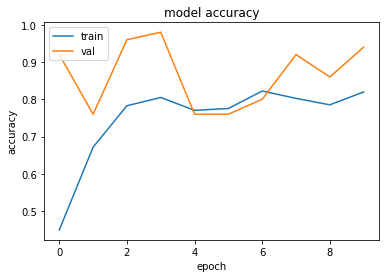

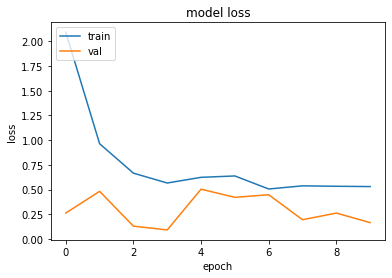

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_results(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
plot_results(history)

In [14]:
# test 
pred = model.predict_generator(test_generator)
predicted_class_indices = np.argmax(pred, axis = 1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [15]:
results_df = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
results_df['id'] = results_df.id.str.extract('(\d+)')
results_df['id'] = pd.to_numeric(results_df['id'], errors = 'coerce')
results_df.sort_values(by='id', inplace = True)
results_df.head()

,id,label
101,2,2
60,3,1
228,5,4
231,6,1
234,7,4


In [16]:
scores = model.evaluate_generator(test_generator) 
model.metrics_names

Instructions for updating:
Please use Model.evaluate, which supports generators.


['loss', 'accuracy']

In [17]:
print('Accuracy:', scores[1])

Accuracy: 0.804780900478363


Epoch 1/10
81/81 [==============================] - 27s 339ms/step - loss: 0.4940 - accuracy: 0.8519 - val_loss: 0.2951 - val_accuracy: 0.8600
Epoch 2/10
81/81 [==============================] - 27s 328ms/step - loss: 0.4134 - accuracy: 0.8617 - val_loss: 0.4065 - val_accuracy: 0.8000
Epoch 3/10
81/81 [==============================] - 27s 334ms/step - loss: 0.4588 - accuracy: 0.8543 - val_loss: 0.1583 - val_accuracy: 0.9200
Epoch 4/10
81/81 [==============================] - 26s 321ms/step - loss: 0.3526 - accuracy: 0.8642 - val_loss: 0.2094 - val_accuracy: 0.9000
Epoch 5/10
81/81 [==============================] - 28s 340ms/step - loss: 0.4271 - accuracy: 0.8444 - val_loss: 0.1454 - val_accuracy: 0.9000
Epoch 6/10
81/81 [==============================] - 27s 336ms/step - loss: 0.3007 - accuracy: 0.8988 - val_loss: 0.1030 - val_accuracy: 0.9600
Epoch 7/10
81/81 [==============================] - 27s 330ms/step - loss: 0.3904 - accuracy: 0.8691 - val_loss: 0.2515 - val_accuracy: 0.9200

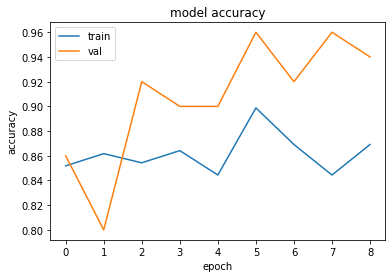

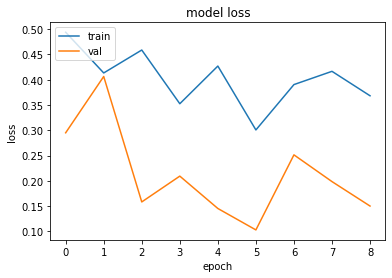

Accuracy: 0.8406374454498291


In [18]:
EARLY_STOP_PATIENCE=3
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'best_resnet50.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

history = model.fit_generator(train_generator, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator) // BS,
                    steps_per_epoch=len(train_generator) // BS, 
                    epochs=EPOCHS,
                    callbacks=[cb_checkpointer, cb_early_stopper])
plot_results(history)
scores = model.evaluate_generator(test_generator) 
print('Accuracy:', scores[1])

In [19]:
import os
classes = os.listdir('dataset-resized/test/')
total = []
for i in range(0, len(classes)):
    path, dirs, files = next(os.walk("dataset-resized/test/" + classes[i]))
    total.append(len(files))
total

[59, 41, 40, 13, 50, 48]

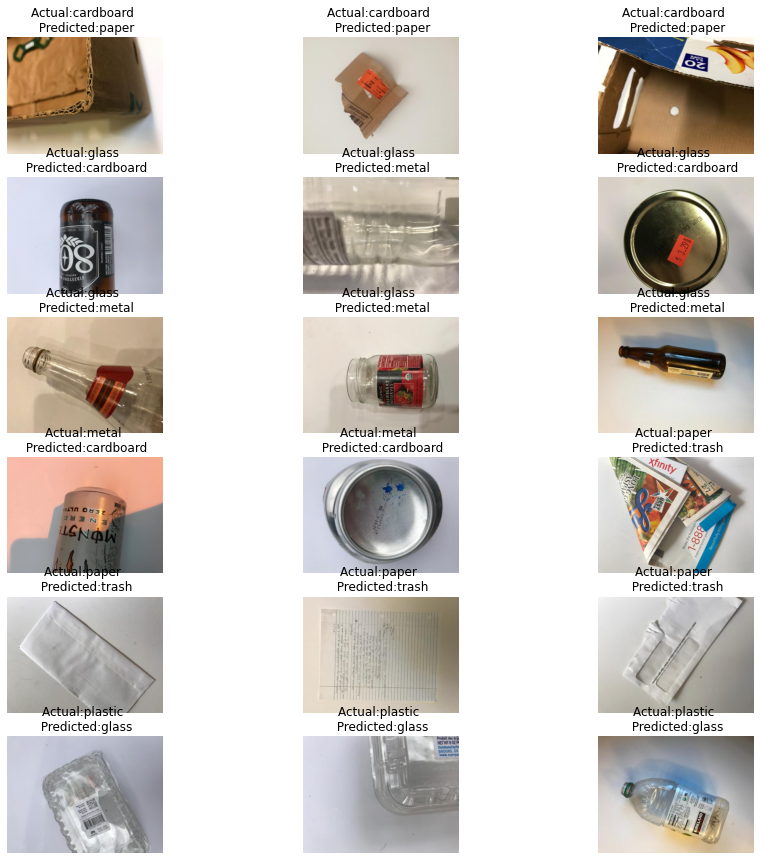

In [20]:
# example: #https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
import os
classes = os.listdir('dataset-resized/test/')
import cv2
TEST_DIR = 'dataset-resized/test/'
f, ax = plt.subplots(6, 3, figsize = (15, 15))

j=0
index = 0
for j in range(0, len(classes)):
    for i in range(0, 3):
        imgBGR = cv2.imread(TEST_DIR + test_generator.filenames[index])
        imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
        ax[j, i].imshow(imgRGB)
        ax[j, i].axis('off')
        ax[j, i].set_title("Actual:{} \n Predicted:{}".format((test_generator.filenames[index].split('/')[0]), 
                                                 classes[predicted_class_indices[index]]))    
        index = index+1
    index = index + total[i]
plt.show()